In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

emotion = load_dataset("emotion")

c:\Users\User\.conda\envs\torch\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


# 1. Pandas exploration

In [2]:
emotion.set_format("pandas")
train_df = emotion["train"][:]
test_df = emotion["test"][:]

In [3]:
train_df["lbl_name"] = train_df["label"].apply(lambda x: emotion["train"].features["label"].int2str(x))
train_df

,text,label,lbl_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


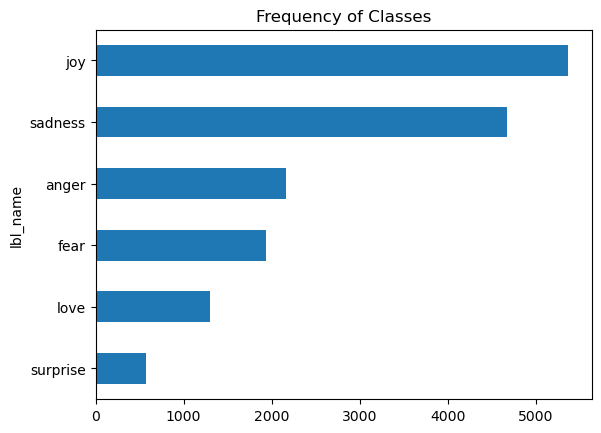

In [4]:
# Check for data imbalances
train_df["lbl_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

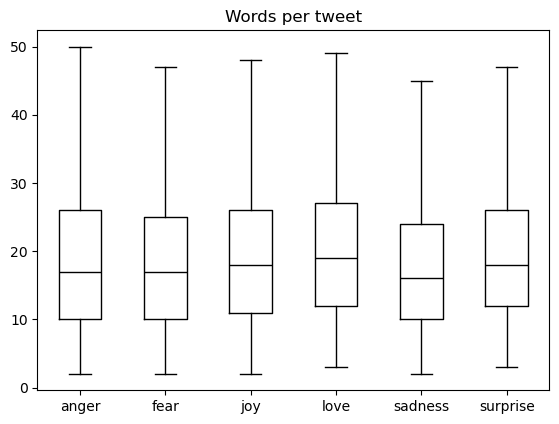

In [5]:
# Check for tweet length
train_df["Words per tweet"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words per tweet", by="lbl_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [6]:
emotion.reset_format()

# 2. After pandas

In [7]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    model_ckpt,
)

In [8]:
text = "Tokenizing text is a core task of NLP"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '[SEP]']

In [10]:
def tokenize(batch):
   return tokenizer(batch["text"], padding=True, truncation=True)


In [11]:
tokenize(emotion["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [12]:
emotion_encoded = emotion.map(tokenize, batched=True, batch_size=None)
print(emotion_encoded)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [13]:
print(emotion_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [14]:
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [15]:
# Pytorch getting last hidden state
text ="this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(inputs["input_ids"].size())

torch.Size([1, 6])


In [16]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [17]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.inference_mode():
   outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [18]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [19]:
def extract_hidden_states(batch):
   inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
   with torch.inference_mode():
      last_hidden_state = model(**inputs).last_hidden_state
   return{"hidden_state":last_hidden_state[:,0].cpu().numpy()}

In [20]:
emotion_encoded.set_format("torch", columns=["input_ids","attention_mask","label"])
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [21]:
emotion_hidden = emotion_encoded.map(extract_hidden_states, batched=True)
emotion_hidden

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [22]:
emotion_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [23]:
import numpy as np

X_train = np.array(emotion_hidden["train"]["hidden_state"])
X_valid = np.array(emotion_hidden["validation"]["hidden_state"])
y_train = np.array(emotion_hidden["train"]["label"])
y_valid = np.array(emotion_hidden["validation"]["label"])
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((16000, 768), (16000,), (2000, 768), (2000,))

In [26]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.950604,6.497509,0
1,-3.113810,5.290119,0
2,5.463216,2.952627,3
3,-2.397593,2.993992,2
4,-3.291191,3.159931,3


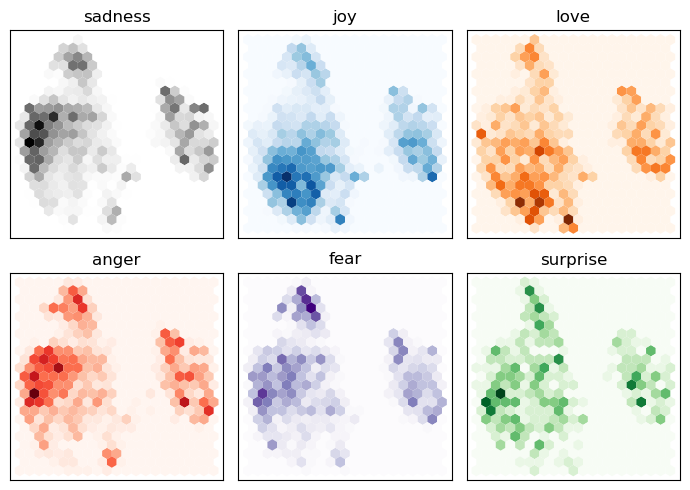

In [36]:
fig, axes = plt.subplots(2,3,figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys","Blues","Oranges","Reds","Purples","Greens"]
labels = emotion["train"].features["label"].names

for i,(label,cmap) in enumerate(zip(labels,cmaps)):
   df_emb_sub = df_emb.query(f"label == {i}")
   axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20,linewidths=(0,))
   axes[i].set_title(label)
   axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()